In [1]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('transforming').getOrCreate()

In [2]:
# Importing data which has a header and automatically configuring the schema.
#df = spark.read.format("csv").load("Datasets/forestfires_merged.csv", inferSchema=True, header=True)
df = spark.read.csv("Datasets/forestfires_merged.csv", inferSchema=True, header=True)

In [3]:
from pyspark.ml.feature import StringIndexer

# convert categorical features to numeric
indexerDay = StringIndexer(inputCol='day', outputCol='dayIndex')
df = indexerDay.fit(df).transform(df)
df.show()
df.printSchema()

+---+---+---+---+-----+---+----+-----+-----+----+----+---+----+----+----+-------------+--------+
|id1|id2|  X|  Y|month|day|FFMC|  DMC|   DC| ISI|temp| RH|wind|rain|fire|month nominal|dayIndex|
+---+---+---+---+-----+---+----+-----+-----+----+----+---+----+----+----+-------------+--------+
|  0|  0|  7|  5|  mar|fri|86.2| 26.2| 94.3| 5.1| 8.2| 51| 6.7| 0.0|   0|            3|     1.0|
|  1|  2|  7|  4|  oct|sat|90.6| 43.7|686.9| 6.7|14.6| 33| 1.3| 0.0|   0|           10|     2.0|
|  2|  3|  8|  6|  mar|fri|91.7| 33.3| 77.5| 9.0| 8.3| 42| 4.0| 0.2|   0|            3|     1.0|
|  3|  4|  8|  6|  mar|sun|89.3| 51.3|102.2| 9.6|11.4| 42| 1.8| 0.0|   0|            3|     0.0|
|  4|  5|  8|  6|  aug|sun|92.3| 85.3|488.0|14.7|22.2| 29| 5.4| 0.0|   0|            8|     0.0|
|  5|  6|  8|  6|  aug|mon|92.3| 88.9|495.6| 8.5|24.1| 27| 3.1| 0.0|   0|            8|     3.0|
|  6|  7|  8|  6|  aug|mon|91.5|145.4|608.2|10.7| 8.0| 42| 2.2| 0.0|   0|            8|     3.0|
|  7|  8|  8|  6|  sep|tue|91.

In [4]:
# Converting csv df to vector
from pyspark.ml.feature import VectorAssembler

# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
vector_assembler = VectorAssembler(inputCols = ['X', 'Y', 'FFMC', 'month nominal', 'dayIndex','DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], outputCol = 'features')

# Now that we've created the assembler variable, let's actually transform the data.
vector_output = vector_assembler.transform(df)
#vector_output.show()

# Because the features have been combined into one vector, we no longer need them. Below we select the features and label.
vector_output = vector_output.select(['features', 'fire'])

# You can see that the dataframe now only contains two columns. 
print(vector_output.head(1))
vector_output.show(3)

[Row(features=DenseVector([7.0, 5.0, 86.2, 3.0, 1.0, 26.2, 94.3, 5.1, 8.2, 51.0, 6.7, 0.0]), fire=0)]
+--------------------+----+
|            features|fire|
+--------------------+----+
|[7.0,5.0,86.2,3.0...|   0|
|[7.0,4.0,90.6,10....|   0|
|[8.0,6.0,91.7,3.0...|   0|
+--------------------+----+
only showing top 3 rows



In [6]:
# Finding top predictors using ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=5, featuresCol="features", outputCol="selectedFeatures", labelCol="fire")
result = selector.fit(vector_output).transform(vector_output)
model = selector.fit(vector_output)
importantFeatures = model.selectedFeatures

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
print(importantFeatures)
result.show()

ChiSqSelector output with top 5 features selected
[5, 6, 8, 9, 7]
+--------------------+----+--------------------+
|            features|fire|    selectedFeatures|
+--------------------+----+--------------------+
|[7.0,5.0,86.2,3.0...|   0|[26.2,94.3,5.1,8....|
|[7.0,4.0,90.6,10....|   0|[43.7,686.9,6.7,1...|
|[8.0,6.0,91.7,3.0...|   0|[33.3,77.5,9.0,8....|
|[8.0,6.0,89.3,3.0...|   0|[51.3,102.2,9.6,1...|
|[8.0,6.0,92.3,8.0...|   0|[85.3,488.0,14.7,...|
|[8.0,6.0,92.3,8.0...|   0|[88.9,495.6,8.5,2...|
|[8.0,6.0,91.5,8.0...|   0|[145.4,608.2,10.7...|
|[8.0,6.0,91.0,9.0...|   0|[129.5,692.6,7.0,...|
|[7.0,5.0,92.5,9.0...|   0|[88.0,698.6,7.1,2...|
|[7.0,5.0,92.5,9.0...|   0|[88.0,698.6,7.1,1...|
|[7.0,5.0,92.8,9.0...|   0|[73.2,713.0,8.4,1...|
|[6.0,5.0,91.6,8.0...|   0|[70.8,665.3,0.8,1...|
|[6.0,5.0,90.9,9.0...|   0|[126.5,686.5,7.0,...|
|[6.0,5.0,92.9,9.0...|   0|[133.3,699.6,9.2,...|
|[6.0,5.0,93.3,9.0...|   0|[141.2,713.9,13.9...|
|[8.0,5.0,91.6,10....|   0|[32.8,664.2,3.0,1...|
|[6

In [5]:
df_reduced = df.select('DMC', 'DC', 'temp', 'RH', 'ISI', 'month nominal', 'fire')
df_reduced.show()

+-----+-----+----+---+----+-------------+----+
|  DMC|   DC|temp| RH| ISI|month nominal|fire|
+-----+-----+----+---+----+-------------+----+
| 26.2| 94.3| 8.2| 51| 5.1|            3|   0|
| 43.7|686.9|14.6| 33| 6.7|           10|   0|
| 33.3| 77.5| 8.3| 42| 9.0|            3|   0|
| 51.3|102.2|11.4| 42| 9.6|            3|   0|
| 85.3|488.0|22.2| 29|14.7|            8|   0|
| 88.9|495.6|24.1| 27| 8.5|            8|   0|
|145.4|608.2| 8.0| 42|10.7|            8|   0|
|129.5|692.6|13.1| 63| 7.0|            9|   0|
| 88.0|698.6|22.8| 40| 7.1|            9|   0|
| 88.0|698.6|17.8| 51| 7.1|            9|   0|
| 73.2|713.0|19.3| 38| 8.4|            9|   0|
| 70.8|665.3|17.0| 72| 0.8|            8|   0|
|126.5|686.5|21.3| 42| 7.0|            9|   0|
|133.3|699.6|26.4| 21| 9.2|            9|   0|
|141.2|713.9|22.9| 44|13.9|            9|   0|
| 32.8|664.2|16.7| 47| 3.0|           10|   0|
| 27.9| 70.8|15.9| 35| 6.3|            3|   0|
| 27.4| 97.1| 9.3| 44| 5.1|            4|   0|
|129.5|692.6|

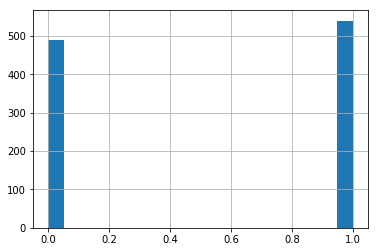

In [24]:
import pandas as pd
import matplotlib

df_pandas = df_reduced.toPandas()
df_pandas['fire'].hist(bins=20)

In [28]:
from pyspark.ml.feature import Normalizer

normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
normalised_output = normalizer.transform(vector_output)
print("Normalized using L^1 norm")
normalised_output.show()

Normalized using L^1 norm
+--------------------+----+--------------------+
|            features|fire|        normFeatures|
+--------------------+----+--------------------+
|[7.0,5.0,86.2,3.0...|   0|[0.02383384405856...|
|[7.0,4.0,90.6,10....|   0|[0.00777950655701...|
|[8.0,6.0,91.7,3.0...|   0|[0.02816901408450...|
|[8.0,6.0,89.3,3.0...|   0|[0.02464571780653...|
|[8.0,6.0,92.3,8.0...|   0|[0.01054157332981...|
|[8.0,6.0,92.3,8.0...|   0|[0.01046435578809...|
|[8.0,6.0,91.5,8.0...|   0|[0.00857449088960...|
|[8.0,6.0,91.0,9.0...|   0|[0.00777756173439...|
|[7.0,5.0,92.5,9.0...|   0|[0.00717213114754...|
|[7.0,5.0,92.5,9.0...|   0|[0.00710515631343...|
|[7.0,5.0,92.8,9.0...|   0|[0.00720386950704...|
|[6.0,5.0,91.6,8.0...|   0|[0.00635458589281...|
|[6.0,5.0,90.9,9.0...|   0|[0.00600360216129...|
|[6.0,5.0,92.9,9.0...|   0|[0.00592358574390...|
|[6.0,5.0,93.3,9.0...|   0|[0.00568397120121...|
|[8.0,5.0,91.6,10....|   0|[0.00902730760550...|
|[6.0,4.0,89.2,3.0...|   0|[0.0223797090637

In [30]:
normalised_output = normalised_output.select(['normFeatures', 'fire'])
normalised_output.show()

+--------------------+----+
|        normFeatures|fire|
+--------------------+----+
|[0.02383384405856...|   0|
|[0.00777950655701...|   0|
|[0.02816901408450...|   0|
|[0.02464571780653...|   0|
|[0.01054157332981...|   0|
|[0.01046435578809...|   0|
|[0.00857449088960...|   0|
|[0.00777756173439...|   0|
|[0.00717213114754...|   0|
|[0.00710515631343...|   0|
|[0.00720386950704...|   0|
|[0.00635458589281...|   0|
|[0.00600360216129...|   0|
|[0.00592358574390...|   0|
|[0.00568397120121...|   0|
|[0.00902730760550...|   0|
|[0.02237970906378...|   0|
|[0.02071108042802...|   0|
|[0.00597550044816...|   0|
|[0.01441812564366...|   0|
+--------------------+----+
only showing top 20 rows

